In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.panel.data import PanelData
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects, compare
import matplotlib.pyplot as plt
from plot_result import plot_result

In [2]:
df=pd.read_csv("../../data/merged/len3_ship_mon_Y_DN.csv",encoding="shift-jis",index_col=0)
df["ship_date"]

0       2009-01-31
1       2009-02-28
2       2009-03-31
3       2009-04-30
4       2009-05-31
           ...    
4195    2022-08-31
4196    2022-09-30
4197    2022-10-31
4198    2022-11-30
4199    2022-12-31
Name: ship_date, Length: 4200, dtype: object

Estimation

In [3]:
df=pd.concat([df,pd.get_dummies(df["month"],prefix="mon")],axis=1)
df["mon_1"]

0       1
1       0
2       0
3       0
4       0
       ..
4195    0
4196    0
4197    0
4198    0
4199    0
Name: mon_1, Length: 4200, dtype: uint8

In [4]:
# normalization of year
# 2008で正規化するかで結構estimateが変わります、1ぐらい
# df["year"]=df["year"]-2008

#前処理
df.replace('-',"0",inplace=True)
df["otc_dom"].replace(",","",regex=True,inplace=True)
df["rx_dom"].replace(",","",regex=True,inplace=True)
df["stock_otc_lag"].replace(",","",regex=True,inplace=True)
df["stock_rx_lag"].replace(",","",regex=True,inplace=True)
# fillna
df["otc_dom"].fillna(0,inplace=True)
df["rx_dom"].fillna(0,inplace=True)
df["stock_otc_lag"].fillna(0,inplace=True)
df["stock_rx_lag"].fillna(0,inplace=True)

df["otc_dom"]=df["otc_dom"].astype(int)
df["rx_dom"]=df["rx_dom"].astype(int)
df["stock_otc_lag"]=df["stock_otc_lag"].astype(int)
df["stock_rx_lag"]=df["stock_rx_lag"].astype(float)
#ここはかなり重要でセレクションバイアスみたいなので有意性が変わるらしい
df=df.loc[df["otc_dom"]>0]
df=df.loc[df["rx_dom"]>0]
# df=df.loc[df["stock_otc_lag"]>0]
# df=df.loc[df["stock_rx_lag"]>0]
df=df.loc[df["generic_share_q"]>0]
# make log columns
df["log_rx_dom"]=np.log(df["rx_dom"])
df["log_otc_dom"]=np.log(df["otc_dom"])
df["log_stock_rx_lag"]=np.log(df["stock_rx_lag"])
df["log_stock_otc_lag"]=np.log(df["stock_otc_lag"])

# make year trend
df["year_trend"]=df["year"]-2008

c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\hakos\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
# change to the datetime format
df['ship_date'] = pd.to_datetime(df["ship_date"], format='%Y-%m-%d')
df=df.set_index(["id","ship_date"])
# df=df.set_index(["id","year"])

df.info()
# make this to paneldata
df=PanelData(df,convert_dummies=False)
df.shape

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2824 entries, (114, Timestamp('2009-01-31 00:00:00')) to (799, Timestamp('2022-12-31 00:00:00'))
Columns: 117 entries, year to year_trend
dtypes: float64(14), int32(3), int64(79), object(9), uint8(12)
memory usage: 2.3+ MB


(117, 168, 21)

In [6]:
months="+mon_1+mon_2+mon_3+mon_4+mon_5+mon_6+mon_7+mon_8+mon_9+mon_10+mon_11+mon_12"
ytrend="+year_trend"

stockのlag(むしろgeneric?)とtime effectは共存できないらしい

elapsed dummies


In [7]:
before_p=10
after_p=15
elapsed = ''.join(["+elapsed_m" + str(i) for i in range(before_p, 1, -1)])
elapsed=elapsed+''.join(["+elapsed_" + str(i) for i in range(0,after_p+1)])
print(elapsed)

+elapsed_m10+elapsed_m9+elapsed_m8+elapsed_m7+elapsed_m6+elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15


## RX

                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
elapsed_m10    -0.1459     0.1335    -1.0928     0.2746     -0.4077      0.1159
elapsed_m9     -0.0225     0.0999    -0.2253     0.8217     -0.2184      0.1734
elapsed_m8      0.0237     0.0906     0.2613     0.7939     -0.1540      0.2014
elapsed_m7     -0.0329     0.0937    -0.3516     0.7252     -0.2167      0.1508
elapsed_m6      0.0974     0.0670     1.4544     0.1459     -0.0339      0.2287
elapsed_m5      0.0179     0.0620     0.2886     0.7729     -0.1037      0.1394
elapsed_m4      0.0761     0.0780     0.9750     0.3297     -0.0769      0.2290
elapsed_m3      0.0119     0.0604     0.1977     0.8433     -0.1064      0.1303
elapsed_m2      0.0681     0.0645     1.0562     0.2910     -0.0584      0.1947
elapsed_0       0.0836     0.0668     1.

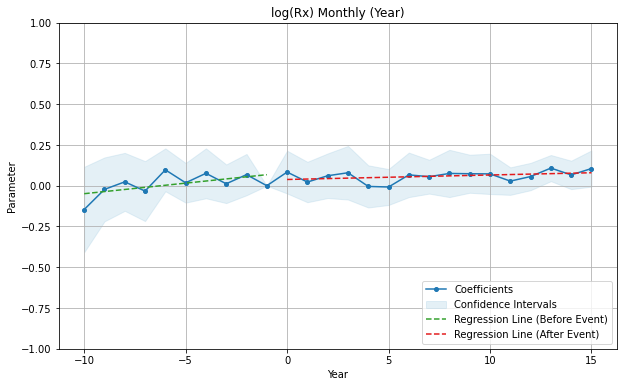

In [13]:
# take log
formula="log_rx_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_rx_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + generic_share_r"
# generic_share_q
# formula+="+log(generic_per)"
# formula+=" + log(generic_share_q)"
# fixed effects
formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True,check_rank=False)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
plot_result(res_fe,file_name="rx_log_mon_Y_cov",title="log(Rx) Monthly (Year)",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)

### OTC

                              Parameter Estimates                              
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
elapsed_m10    -0.0239     0.1761    -0.1356     0.8921     -0.3691      0.3214
elapsed_m9      0.0534     0.2590     0.2062     0.8367     -0.4544      0.5612
elapsed_m8     -0.0846     0.3232    -0.2619     0.7934     -0.7185      0.5492
elapsed_m7     -0.4346     0.4016    -1.0822     0.2793     -1.2220      0.3529
elapsed_m6     -0.3795     0.2367    -1.6031     0.1090     -0.8437      0.0847
elapsed_m5     -0.0295     0.1969    -0.1500     0.8808     -0.4156      0.3566
elapsed_m4     -0.0542     0.2379    -0.2278     0.8198     -0.5207      0.4123
elapsed_m3      0.0464     0.2711     0.1713     0.8640     -0.4851      0.5780
elapsed_m2      0.0979     0.1969     0.4974     0.6189     -0.2881      0.4840
elapsed_0       0.2155     0.1012     2.

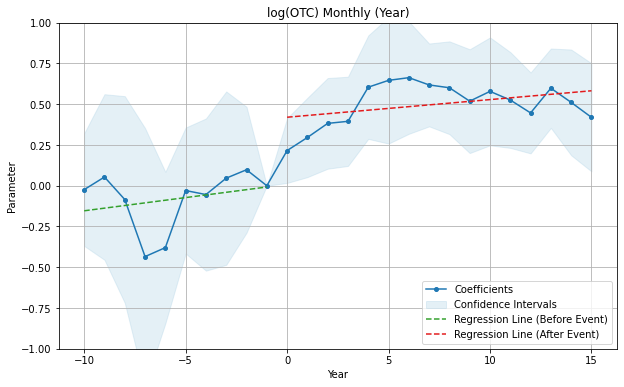

In [14]:
# take log

# till 20
# formula="log_otc_dom ~ elapsed_m5+elapsed_m4+elapsed_m3+elapsed_m2+elapsed_0+elapsed_1+elapsed_2+elapsed_3+elapsed_4+elapsed_5+elapsed_6+elapsed_7+elapsed_8+elapsed_9+elapsed_10+elapsed_11+elapsed_12+elapsed_13+elapsed_14+elapsed_15+elapsed_16+elapsed_17+elapsed_18+elapsed_19+elapsed_20+generic_per+TimeEffects+EntityEffects"

# take log
formula="log_otc_dom ~ "+elapsed


# log_stock_rx_lag
# formula+=" + log_stock_otc_lag"
# ytrend
# formula+=ytrend
# months
# formula+=months
# generic_share_r
# formula+=" + generic_share_r"
# formula+="+log(generic_per)"
# generic_share_q
# formula+=" + log(generic_share_q)"

formula+="+ TimeEffects+EntityEffects"
mod_fe=PanelOLS.from_formula(formula, data=df,drop_absorbed=True)
res_fe=mod_fe.fit(cov_type='clustered', cluster_entity=True)
# res_fe=mod_fe.fit()
print(res_fe.summary.tables[1])
print(res_fe.summary.tables[0])
# print(res_fe)
plot_result(res_fe,file_name="otc_log_mon_Y_cov",title="log(OTC) Monthly (Year)",ylim=(-1,1),plot_type="-o",period=before_p+after_p,insert_index=before_p-1,time_start=-before_p,markersize=4)